In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as fn
from scipy.stats import mode
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import count, col
from pyspark.sql.types import FloatType, DoubleType, DecimalType
import warnings
import os

# Start A Spark Session

In [2]:
# Initialise a sparksession with Hive Store Support
warnings.filterwarnings('ignore')


spark = SparkSession.builder \
        .master('local[4]')\
        .enableHiveSupport()\
        .appName('Research_Notebook')\
        .config('spark.driver.memory','16G') \
        .config('spark.executor.memory','16G') \
        .config('spark.eventLog.enabled', False)\
        .config('spark.sql.execution.arrow.pyspark.enabled', True) \
        .config('spark.ui.showConsoleProgress', True) \
        .config('spark.sql.repl.eagerEval.enabled', True) \
        .config('spark.jars', '/home/jovyan/work/Downloads/spark-bigquery-with-dependencies_2.12-0.22.0.jar') \
        .getOrCreate()

21/11/27 05:22:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark

In [3]:
# Ensure ecommerce_logs database is selected

spark.sql("use ecommerce_logs")

21/11/27 05:23:05 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
21/11/27 05:23:05 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
21/11/27 05:23:16 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
21/11/27 05:23:16 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.2
21/11/27 05:23:17 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


""


In [4]:
spark.catalog.clearCache()

# Load and save data from Bigquery table

In [9]:
def load_data():
    df = spark.read.format('bigquery') \
        .option("credentialsFile", "/home/jovyan/work/my-project-55555-327612-b044a507aca8.json")\
        .option('parentProject','my-project-55555-327612') \
        .option('table', 'my-project-55555-327612.Research_data.dataset')\
        .load()
    
    return df    
df = load_data()

In [10]:
df.printSchema()

root
 |-- fullVisitorId: string (nullable = true)
 |-- visitId: long (nullable = true)
 |-- visitStartTime: long (nullable = true)
 |-- date: string (nullable = true)
 |-- bounceRate: double (nullable = true)
 |-- userConversionRate: double (nullable = true)
 |-- usersRevenue: double (nullable = true)
 |-- sessionQualityDim: long (nullable = true)
 |-- dailyVisits: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- pageviews: long (nullable = true)
 |-- hits: long (nullable = true)
 |-- timeOnSite: long (nullable = true)
 |-- action_type: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- productListPosition: long (nullable = true)
 |-- productPrice: double (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productClicksCount: long (nullable = true)
 |-- month: long (nullable = true)
 |-- target: long (nullable = true)



In [11]:
df.limit(3).toPandas()

,fullVisitorId,visitId,visitStartTime,date,bounceRate,userConversionRate,usersRevenue,sessionQualityDim,dailyVisits,transactions,...,hits,timeOnSite,action_type,browser,productListPosition,productPrice,v2ProductName,productClicksCount,month,target
0,112634254987821526,1490431206,1490431206,20170325,NaN,NaN,NaN,NaN,1,NaN,...,36,688,0,Chrome,9,10.99,Android Twill Cap,0,3,NaN
1,519808012887792629,1490456843,1490456843,20170325,NaN,NaN,NaN,NaN,1,NaN,...,20,1344,0,Chrome,4,17.99,Android Lunch Kit,0,3,NaN
2,9195083470481203141,1490460247,1490460247,20170325,NaN,NaN,NaN,NaN,1,NaN,...,4,54,0,Safari,2,4.50,Fashion Sunglasses & Pouch,0,3,NaN


In [12]:
df.write.format("ORC").saveAsTable("db_researchData")

21/11/26 19:30:24 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
21/11/26 19:30:24 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
21/11/26 19:30:24 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
21/11/26 19:30:24 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


# Exploratory Data Analysis

In [34]:
# Popular products according to views

sql = """
        SELECT
          v2productName AS products,
          COUNT(*) AS views,
          action_type
        FROM
          db_researchData
        GROUP BY
          action_type,
          v2productName
        ORDER BY
          views DESC
        LIMIT
          10
      """

products_views = spark.sql(sql).toPandas()
products_views

,products,views,action_type
0,YouTube Twill Cap,113883,0
1,22 oz YouTube Bottle Infuser,107979,0
2,YouTube Custom Decals,98990,0
3,Google Men's 100% Cotton Short Sleeve Hero Tee...,93322,0
4,YouTube Hard Cover Journal,91290,0
5,YouTube RFID Journal,84876,0
6,YouTube Leatherette Notebook Combo,82769,0
7,YouTube Wool Heather Cap Heather/Black,78504,0
8,YouTube Luggage Tag,74238,0
9,YouTube Men's Vintage Henley,69443,0


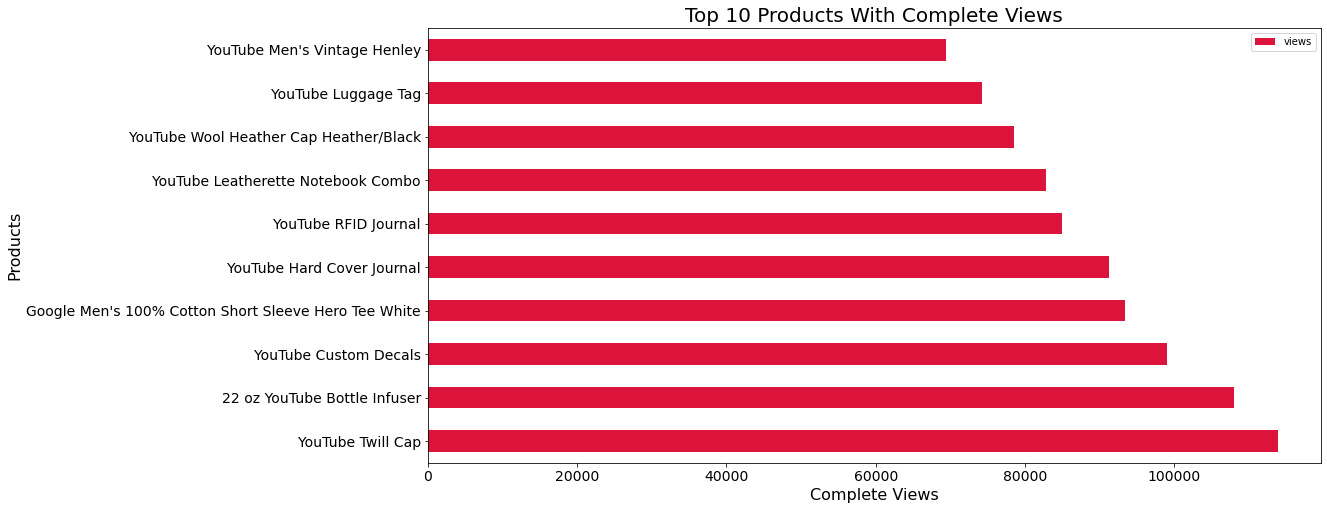

In [36]:
products_views_df = pd.DataFrame(products_views)
products_views_df.set_index('products')
color = ['crimson']

products_views_plot = products_views_df.plot(figsize = (16, 8), kind='barh', x="products", y="views", color=color)
plt.xlabel("Complete Views", fontsize = 16)
plt.ylabel("Products", fontsize = 16)
plt.title("Top 10 Products With Complete Views", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [31]:
# Analyse and compare action type with products and transactions

sql = """
        SELECT
          v2productName AS products,
          SUM(transactions) AS complete_transactions,
          action_type
        FROM
          db_researchData
        WHERE
          action_type = 6
        GROUP BY
          action_type,
          v2productName
        ORDER BY
          complete_transactions DESC
        LIMIT
          10
      """

products_transactions = spark.sql(sql).toPandas()
products_transactions

,products,complete_transactions,action_type
0,Google Laptop and Cell Phone Stickers,390,6
1,Google Sunglasses,358,6
2,Google 22 oz Water Bottle,347,6
3,Google Men's 100% Cotton Short Sleeve Hero Tee...,322,6
4,Google Men's 100% Cotton Short Sleeve Hero Tee...,317,6
5,BLM Sweatshirt,315,6
6,Google Men's Vintage Badge Tee Black,297,6
7,Google Men's Bike Short Sleeve Tee Charcoal,274,6
8,Google Men's 100% Cotton Short Sleeve Hero Tee...,247,6
9,Google Men's Zip Hoodie,232,6


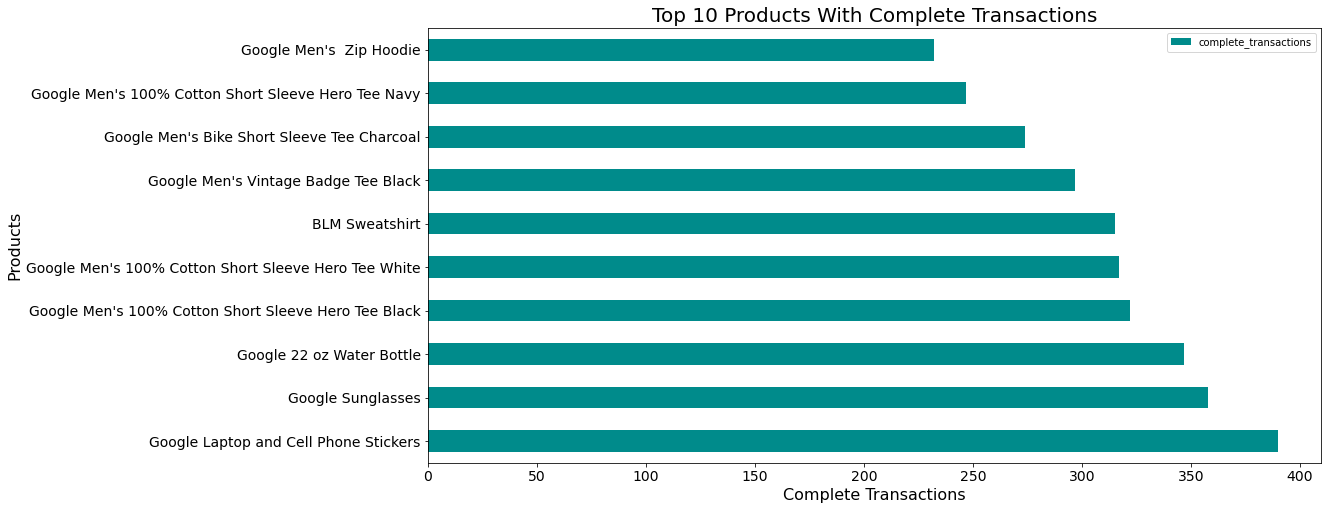

In [32]:
products_transactions_df = pd.DataFrame(products_transactions)
products_transactions_df.set_index('products')
color = ['darkcyan']

products_transactions_plot = products_transactions_df.plot(figsize = (16, 8), kind='barh', x="products", y="complete_transactions", color=color)
plt.xlabel("Complete Transactions", fontsize = 16)
plt.ylabel("Products", fontsize = 16)
plt.title("Top 10 Products With Complete Transactions", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [22]:
# popular broswers accoring to page views

sql = """
        SELECT
          browser,
          COUNT(browser) AS views
        FROM
          db_researchData
        GROUP BY
          browser
        ORDER BY
          views DESC
        LIMIT
          5
      """
browsers = spark.sql(sql).toPandas()
browsers

,browser,views
0,Chrome,4729562
1,Safari,1047059
2,Firefox,227399
3,Internet Explorer,97884
4,Edge,68321


# Feature Engineering,  Data Cleaning and Preprocessing

In [5]:
# extract the fields needed
sql = """
      SELECT
          visitStartTime,
          bounceRate, 
          userConversionRate, 
          pageviews,
          hits, 
          timeOnSite,
          dailyVisits,
          sessionQualityDim,
          action_type,
          productClicksCount,
          productPrice,
          month,
          productListPosition,
        CASE
            WHEN browser = 'Chrome' THEN 1
            WHEN browser = 'Safari' THEN 2
            WHEN browser = 'Firefox' THEN 3
            WHEN browser = 'Internet Explorer' THEN 4
            WHEN browser = 'Edge' THEN 5
            ELSE 0
          END AS browser,
          target
      
      FROM 
         db_researchData
      """

df = spark.sql(sql)
df.limit(4).toPandas()

,visitStartTime,bounceRate,userConversionRate,pageviews,hits,timeOnSite,dailyVisits,sessionQualityDim,action_type,productClicksCount,productPrice,month,productListPosition,browser,target
0,1490431206,NaN,NaN,27,36,688,1,NaN,0,0,10.99,3,9,1,NaN
1,1490456843,NaN,NaN,20,20,1344,1,NaN,0,0,17.99,3,4,1,NaN
2,1490460247,NaN,NaN,4,4,54,1,NaN,0,0,4.50,3,2,2,NaN
3,1490507818,NaN,NaN,4,4,15,1,NaN,0,0,9.99,3,8,1,NaN


In [57]:
# check for duplicates

df.count(), df.distinct().count()

(6348968, 6105523)

In [6]:
# Remove duplicates and confirm

df = df.dropDuplicates()

df.count(), df.distinct().count()

(6105523, 6105523)

In [59]:
# Count and check for missing and/or null values in the columns selected

def df_count(df):
    df_col_count = df.agg(*[count(c).alias(c) for c in df.columns])
    return df_col_count
    
df_count(df)

visitStartTime,bounceRate,userConversionRate,pageviews,hits,timeOnSite,dailyVisits,sessionQualityDim,action_type,productClicksCount,productPrice,month,productListPosition,browser,target
6105523,894675,320027,6105413,6105523,5207371,6105523,919662,6105523,6105523,6105523,6105523,6105523,6105523,320027


In [60]:
# check the statistics of the data
df.describe()

summary,visitStartTime,bounceRate,userConversionRate,pageviews,hits,timeOnSite,dailyVisits,sessionQualityDim,action_type,productClicksCount,productPrice,month,productListPosition,browser,target
count,6105523,894675,320027,6105413,6105523,5207371,6105523,919662,6105523,6105523,6105523,6105523,6105523,6105523,320027
mean,1.4926198136273124E9,1.0,1.092839041705856,11.493936937599472,14.464252939510668,539.1684281761372,1.294804556464696,14.521589453516619,0.1339028613928733,0.03432859068748083,32.228911176112064,4.093554311399695,5.778965700399458,1.2992868915570377,1.0
stddev,5356919.541948093,0.0,0.9054683569417544,15.18535434815819,21.100398311656345,756.4767181401595,1.1107153386634,24.785186415395994,0.6225083119755932,0.3196116629688461,70.20592907843304,2.0360629891201203,3.583042188712223,0.7494640137452594,0.0
min,1483257623,1.0,1.0,1,1,1,1,1,0,0,0.0,1,0,0,1
max,1501657190,1.0,25.0,466,500,12136,576,99,6,441,35532.189,8,15,5,1


In [7]:
# handle missing and null values

df = df.na.fill(0)

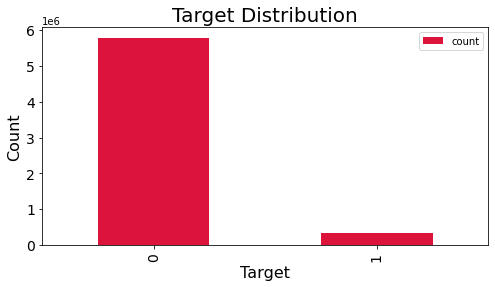

In [45]:
target = df.groupBy('target').count().toPandas()
target_df = pd.DataFrame(target)
target.set_index('count')
color = ['crimson']

target_plot = target_df.plot(figsize = (8, 4), kind='bar', x="target", y="count", color=color)
plt.xlabel("Target", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Target Distribution", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [9]:
df.groupBy('browser').count()

browser,count
1,4532699
3,217898
5,66053
4,94878
2,1018328
0,175667


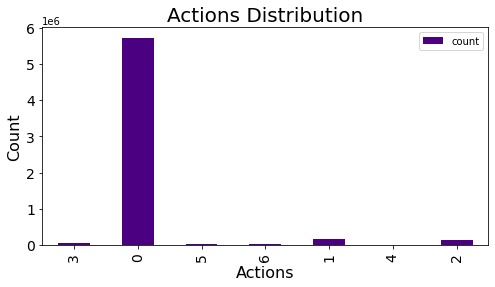

In [46]:
action = df.groupBy('action_type').count().toPandas()
action_df = pd.DataFrame(action)
action.set_index('count')
color = ['indigo']

action_plot = action_df.plot(figsize = (8, 4), kind='bar', x="action_type", y="count", color=color)
plt.xlabel("Actions", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Actions Distribution", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

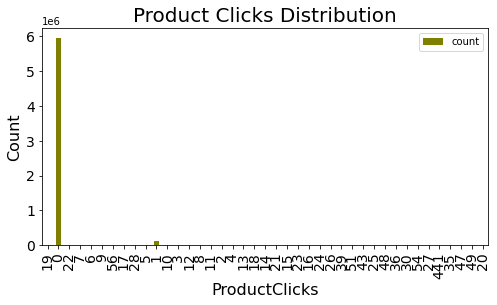

In [62]:
productClicks = df.groupBy('productClicksCount').count().toPandas()
productClicks_df = pd.DataFrame(productClicks)
productClicks.set_index('count')
color = ['olive']

productClicks_plot = productClicks_df.plot(figsize = (8, 4), kind='bar', x="productClicksCount", y="count", color=color)
plt.xlabel("ProductClicks", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Product Clicks Distribution", fontsize = 20, color = 'k')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

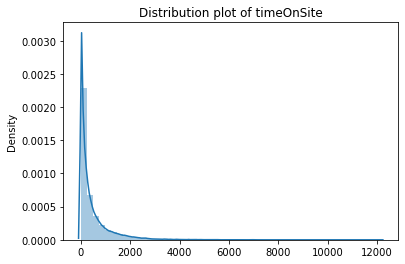

In [49]:
timeOnSite = df.select("timeOnSite").toPandas()


sns.distplot(timeOnSite, x=timeOnSite, kde=True)
plt.title("Distribution plot of timeOnSite")
plt.show()

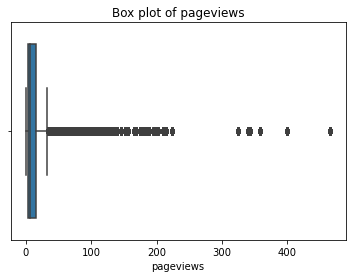

In [50]:
pageviews = df.select("pageviews").toPandas() productClicksCount


sns.boxplot(x=pageviews['pageviews'])
plt.title("Box plot of pageviews")
plt.show()

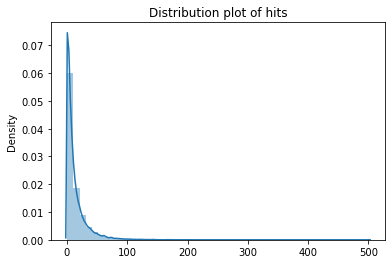

In [53]:
hits = df.select("hits").toPandas()

sns.distplot(hits, x=hits, kde=True)
plt.title("Distribution plot of hits")
plt.show()

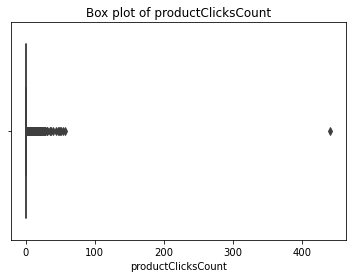

In [54]:
productClicksCount = df.select("productClicksCount").toPandas() 


sns.boxplot(x=productClicksCount['productClicksCount'])
plt.title("Box plot of productClicksCount")
plt.show()

In [218]:
def outlier_df(field):
    QuartilR = None
    lower_quartile = 'lower_{}'.format(field)
    upper_quartile = 'upper_{}'.format(field)
    field_median =   'median_{}'.format(field)
    quartile_dev =   'quartile_dev_{}'.format(field)

    QuartilR = (df.groupBy("fullVisitorId", "visitId", "date")
              .agg(fn.expr('percentile('+field+', array(0.25))')[0].alias(lower_quartile),
                   fn.expr('percentile('+field+', array(0.75))')[0].alias(upper_quartile), 
                   fn.expr('percentile('+field+', array(0.5))')[0].alias(field_median))
              .withColumn(quartile_dev, (fn.col(upper_quartile) - fn.col(lower_quartile))/2))
    return QuartilR

In [219]:
field = "userTransactions"

field_median =   'median_{}'.format(field)
quartile_dev =   'quartile_dev_{}'.format(field)
outlier_removed = (df.join(outlier_df(field), on=["fullVisitorId", "visitId", "date"])
                 .filter(fn.abs(fn.col(field)-fn.col(field_median)) >= (fn.col(quartile_dev)*2.2)))

In [220]:
# save for easy access
outlier_removed.write.format("ORC").saveAsTable("outlier_db")

In [224]:
outlier_df = spark.sql("select * from outlier_db")

outlier_removed = df.count() - outlier_df.count()
outlier_removed

176657

In [227]:
outlier_df.groupBy('target').count().toPandas()

,target,count
0,0,6043599
1,1,173663


In [10]:
# Transaform String Type Columns to Index and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

vector_indexer = StringIndexer(inputCols=["action_type"], outputCols=["action_type_index"], handleInvalid="keep").fit(df)
df_new = vector_indexer.transform(df)
# vector_encoder = OneHotEncoder(inputCols=["fullVisitorId_index","pagePath_index", "action_type_index", "v2ProductCategory_index"], outputCols=["fullVisitorId_vec","pagePath_vec", "action_type_vec", "v2ProductCategory_vec"]).fit(df_new)
# df_vectors = vector_encoder.transform(df_new)

In [65]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Transform dataframe input features,

assembler = (VectorAssembler(inputCols=["visitStartTime",
                                        "bounceRate", 
                                        "userConversionRate", 
                                        "pageviews",
                                        "hits", 
                                        "timeOnSite",
                                        "dailyVisits",
                                        "sessionQualityDim",
                                        "action_type_index",
                                        "browser",
                                        "productClicksCount",
                                        "productPrice",
                                        "month",
                                        "productListPosition", 
                                        "target"],
                             outputCol="features"))

data = assembler.transform(df_new)

data.select("features").show(3)

21/11/26 21:02:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+
|            features|
+--------------------+
|[1.490449171E9,0....|
|[1.487937857E9,0....|
|[1.495242698E9,0....|
+--------------------+
only showing top 3 rows



In [66]:
# Perform Correlation of inputs and output fields

from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(data, "features").head()
print("Pearson correlation matrix \n", str(pearson_corr[0]))

21/11/26 21:02:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/26 21:02:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Pearson correlation matrix 
 DenseMatrix([[ 1.        ,  0.07238329,  0.00157463, -0.05336724, -0.03984732,
              -0.0127655 ,  0.00904399,  0.29366393,  0.01317711, -0.00214665,
               0.00639731, -0.02139534,  0.98978944, -0.01107512,  0.01002693],
             [ 0.07238329,  1.        , -0.07421211, -0.28634203, -0.26424031,
              -0.26309093, -0.10436571, -0.07538007, -0.09120775,  0.06886115,
              -0.04450531, -0.07696227,  0.0722278 ,  0.04777894, -0.0974544 ],
             [ 0.00157463, -0.07421211,  1.        ,  0.45942284,  0.42822407,
               0.30213783,  0.11173508,  0.14692842,  0.20370524, -0.04134156,
               0.01944011,  0.05597646,  0.00283192, -0.05520822,  0.76150595],
             [-0.05336724, -0.28634203,  0.45942284,  1.        ,  0.98507167,
               0.73826483,  0.22826593,  0.21610952,  0.20622449, -0.05279502,
               0.0749983 ,  0.10770476, -0.05301003, -0.07944317,  0.38826559],
             [-0.03

In [67]:
pearson_array = pearson_corr[0].toArray()

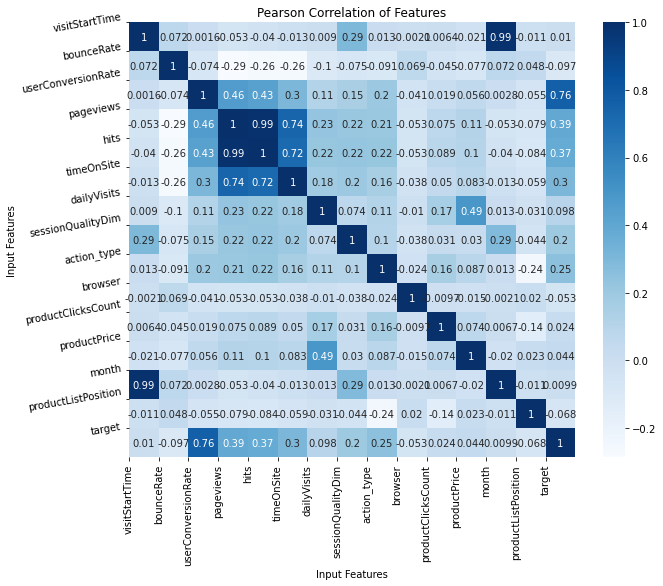

In [68]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
sns.heatmap(pearson_array, annot=True, cmap="Blues", ax=ax)

classes = [ "visitStartTime",
            "bounceRate", 
            "userConversionRate", 
            "pageviews",
            "hits", 
            "timeOnSite",
            "dailyVisits",
            "sessionQualityDim",
            "action_type",
            "browser",
            "productClicksCount",
            "productPrice",
            "month",
            "productListPosition", 
            "target"]

tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes, rotation=10)
plt.xlabel('Input Features')
plt.ylabel('Input Features') 
plt.title('Pearson Correlation of Features')
plt.show()

In [11]:
# Handle Imbalance using weight, calculate ratio of each class

y_collect = df_new.select("target").groupBy("target").count().collect()
unique_y = [x["target"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
class_weights

{0: 0.5276576978015368, 1: 9.539074828061382}

In [12]:
# Use weights to handle imbalance
from itertools import chain

map_expr = fn.create_map([fn.lit(x) for x in chain(*class_weights.items())])

df_new = df_new.withColumn('weights', map_expr.getItem(fn.col('target')))

In [13]:
# Since pageviews, hits and timeOnsite are highly correlated and also correlated to target, use PCA
# to handle this

assembler = VectorAssembler(inputCols=["bounceRate", 
                                       "userConversionRate", 
                                       "pageviews",
                                       "dailyVisits",
                                       "sessionQualityDim",
                                       "action_type_index",
                                       "browser",
                                       "productClicksCount",
                                       "productPrice",
                                       "month",
                                       "productListPosition" 
                                    ], outputCol="assemble_features")

output = assembler.transform(df_new)

output.select("assemble_features", "target").show(3)

+--------------------+------+
|   assemble_features|target|
+--------------------+------+
|(11,[2,3,6,8,9,10...|     0|
|(11,[2,3,6,8,9,10...|     0|
|(11,[2,3,6,8,9,10...|     0|
+--------------------+------+
only showing top 3 rows



In [14]:
# Apply Scaler before splitting
from pyspark.ml.feature import RobustScaler


scaler = RobustScaler(inputCol="assemble_features", outputCol="features",
                        withScaling=True, withCentering=False,
                        lower=0.25, upper=0.75)

scaler_model = scaler.fit(output)

df_scaled = scaler_model.transform(output)
df_scaled.limit(2).toPandas()

,visitStartTime,bounceRate,userConversionRate,pageviews,hits,timeOnSite,dailyVisits,sessionQualityDim,action_type,productClicksCount,productPrice,month,productListPosition,browser,target,action_type_index,weights,assemble_features,features
0,1490449171,0.0,0.0,16,17,273,1,0,0,0,14.99,3,11,2,0,0.0,0.527658,"(0.0, 0.0, 16.0, 1.0, 0.0, 0.0, 2.0, 0.0, 14.9...","(0.0, 0.0, 1.3333333333333333, 0.0, 0.0, 0.0, ..."
1,1487937857,0.0,0.0,9,9,289,1,0,0,0,5.50,2,2,1,0,0.0,0.527658,"(0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 1.0, 0.0, 5.5, ...","(0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20..."


In [15]:
features_label = df_scaled.withColumn("label", col("target"))

# Model Training and Validation

### Split Normalized Data Into Train and Test sets

In [16]:
# Randomly split normalized data into train and test

df_model = features_label.select(["features", "label", "weights"])

train, test = df_model.randomSplit([0.7, 0.3], 56)
print('Test split:', test.count())
print('Train split:', train.count())

Test split: 1831756


Train split: 4273767


In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def model_evaluation(results, metric, evaluator):
    
    predict_label = results.select("prediction", "label")

    
    print(metric + ": " + str(evaluator.evaluate(predict_label)))
    
    return evaluator.evaluate(predict_label)

# Logistic Regression

In [76]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

### Hyperparameter Tuning: Log Regression 

In [130]:
def LogModel(train):
    """
    LogModel initialises the Logistic Regression Model
    for parameter tuning.  
    :train: is the training set of the data
    """
    
    LR = LogisticRegression(maxIter=5, elasticNetParam=0.8, weightCol="weights") 
    
    #set parameters for the model
    param_grid = ParamGridBuilder()\
                .addGrid(LR.regParam, [0.1, 0.2, 0.3]) \
                .build()
    
    #set validation
    val_LR =   CrossValidator(estimator=LR,
                           estimatorParamMaps=param_grid,
                           evaluator=MulticlassClassificationEvaluator(metricName="accuracy", weightCol="weights"),
                           numFolds=10)
    
    #fit the Log Regression model and validation
    model = val_LR.fit(train)

    return model, model.avgMetrics
LR_tune_model, ACU_metric = LogModel(train)
ACU_metric

[0.8193810772544421, 0.8101112489514866, 0.800369462676797]

In [131]:
results = LR_tune_model.bestModel.transform(test)

auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(results, "areaUnderROC",  auc_eval)
model_evaluation(results, "accuracy",  accuracy_eval)
model_evaluation(results, "f1",  f1_eval)
model_evaluation(results, "precision_eval",  precision_eval)
model_evaluation(results, "recallByLabel",  recall_eval)

areaUnderROC: 0.818004885905463


accuracy: 0.879113266177373


f1: 0.9045846111783516


precision_eval: 0.9845937496799566


recallByLabel: 0.8862827231164132


0.8862827231164132

In [132]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictandLabel = results.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

metrics = MulticlassMetrics(predictandLabel)
cm=metrics.confusionMatrix().toArray()

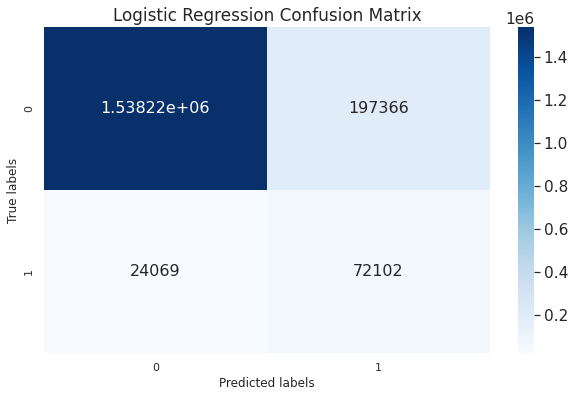

In [145]:
sns.set_theme()
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax, annot_kws={"size": 16})
classes = ["Not Transacting", "Transacting"]

tick_marks = np.arange(len(classes))

plt.xlabel('Predicted labels')
plt.ylabel('True labels') 
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes, rotation=0)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [77]:
LR = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, weightCol="weights")

LR_model = LR.fit(train)

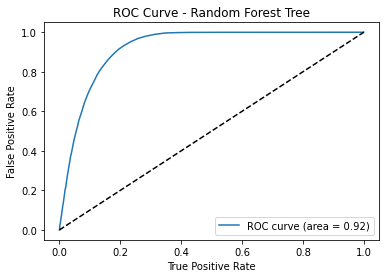

In [78]:
# Test the model
LR_summary = LR_model.summary

LR_result = LR_model.transform(test)

ROC = LR_summary.roc.toPandas()
label = 'ROC curve (area = %.2f)'% LR_summary.areaUnderROC
plt.plot(ROC['FPR'],ROC['TPR'], label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Tree')
plt.legend(loc="lower right")
plt.show()

print('Training set ROC: ' + str(LR_summary.areaUnderROC))

In [79]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(LR_result, "areaUnderROC",  auc_eval)
model_evaluation(LR_result, "accuracy",  accuracy_eval)
model_evaluation(LR_result, "f1",  f1_eval)
model_evaluation(LR_result, "Precision",  precision_eval)
model_evaluation(LR_result, "Recall",  recall_eval)

areaUnderROC: 0.7986453771937666


accuracy: 0.8928951235863292


f1: 0.9129875706141914


Precision: 0.9815488066347218


Recall: 0.9039528458704126


0.9039528458704126

In [84]:
conf_matrix = LR_result.crosstab("prediction", "label")
conf_matrix

prediction_label,0,1
1.0,166698,66679
0.0,1568887,29492


In [56]:
from pyspark.mllib.linalg import Vectors as mllib_vectors
from pyspark.ml.linalg import Vectors as ml_vectors

# y = ml_vectors.dense([13, 2, 20, 6, 1])

# predictn = LRModel.predict(y)
# predictn

In [86]:
#Save Model 
path = "home/jovyan/work/research_model_logR"

LR_model.save(path)

# Random Forest Tree

In [21]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

### Hyperparameter Tuning: Random Forest 

In [146]:
def RFModel(train):
    
    estimator = RandomForestClassifier(seed=42, weightCol="weights")
    
    param_grid = (ParamGridBuilder()\
                 .addGrid(estimator.maxDepth, [4, 7])\
                 .addGrid(estimator.numTrees, [3, 5])\
                 .build())
    
    model_validate =  CrossValidator(estimator=estimator,
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName="accuracy", weightCol="weights"),
                               numFolds=10)
    model = model_validate.fit(train)
    
    return model, model.avgMetrics
RF_model, ACU_Metrics = RFModel(train)

In [147]:
ACU_Metrics

[0.866021730442261, 0.8662318177992587, 0.8673321839770278, 0.8666636437600749]

In [148]:
predictions = RF_model.bestModel.transform(test)

auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(predictions, "areaUnderROC",  auc_eval)
model_evaluation(predictions, "accuracy",  accuracy_eval)
model_evaluation(predictions, "f1",  f1_eval)
model_evaluation(predictions, "precision_eval",  precision_eval)
model_evaluation(predictions, "recallByLabel",  recall_eval)

areaUnderROC: 0.8670968023549739


accuracy: 0.8042659611869704


f1: 0.8563455894545383


precision_eval: 0.9956590848227783


recallByLabel: 0.7968944188846988


0.7968944188846988

In [149]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictandLabel = predictions.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

metrics = MulticlassMetrics(predictandLabel)
cm=metrics.confusionMatrix().toArray()

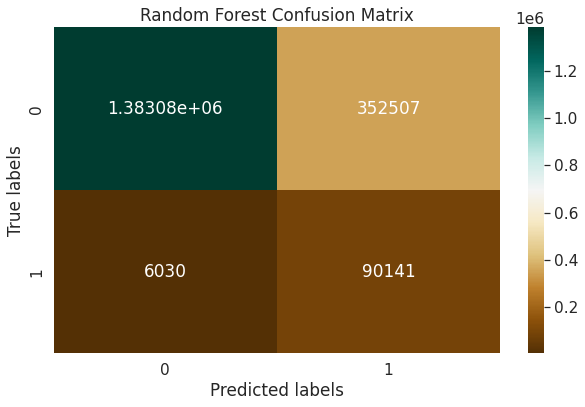

In [155]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap="BrBG", ax=ax)
classes = ["Not Transacting", "Transacting"]

tick_marks = np.arange(len(classes))

plt.xlabel('Predicted labels')
plt.ylabel('True labels') 
# plt.xticks(tick_marks, classes, rotation=0)
# plt.yticks(tick_marks, classes, rotation=0) 
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title('Random Forest Confusion Matrix')
plt.show()

In [88]:
RF = RandomForestClassifier(maxDepth=10, weightCol="weights")
RFModel = RF.fit(train)

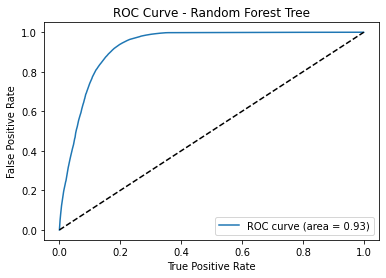

In [89]:
RF_summary = RFModel.summary

RF_result = RFModel.transform(test)



ROC = RF_summary.roc.toPandas()
label = 'ROC curve (area = %.2f)'% RF_summary.areaUnderROC
plt.plot(ROC['FPR'],ROC['TPR'], label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Tree')
plt.legend(loc="lower right")
plt.show()

In [90]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(RF_result, "areaUnderROC",  auc_eval)
model_evaluation(RF_result, "accuracy",  accuracy_eval)
model_evaluation(RF_result, "f1",  f1_eval)
model_evaluation(RF_result, "Precision",  precision_eval)
model_evaluation(RF_result, "Recall",  recall_eval)

areaUnderROC: 0.8684208977236921


accuracy: 0.7964172084054864


f1: 0.8510673216866727


Precision: 0.9964174993898018


Recall: 0.7879694742694826


0.7879694742694826

In [91]:
cm = RF_result.crosstab("prediction", "label")
cm

prediction_label,0,1
1.0,367997,91254
0.0,1367588,4917


In [94]:
#Save Model 
path = "home/jovyan/work/researchModels_RF"
RFModel.save(path)

# Gradient Boosted Tree

In [95]:
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel  

### Hyperparameter Tuning: Gradient Boost 

In [157]:
def GBTModel(train):
        
    estimator = GBTClassifier(maxIter=5, weightCol="weights")
    
    param_grid = (ParamGridBuilder()\
                 .addGrid(estimator.maxDepth, [2, 3, 4])\
                 .build())
    
    model_validate =  CrossValidator(estimator=estimator,
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                               numFolds=10)
    model = model_validate.fit(train)
    
    return model, model.avgMetrics
GBT_model, auc_metrics = GBTModel(train)
auc_metrics

[0.7775434196206802, 0.7895314389418782, 0.8081738939331399]

In [158]:
# Evaluate the best Model

predictions = GBT_model.bestModel.transform(test)

auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(predictions, "areaUnderROC",  auc_eval)
model_evaluation(predictions, "accuracy",  accuracy_eval)
model_evaluation(predictions, "f1",  f1_eval)
model_evaluation(predictions, "precision_eval",  precision_eval)
model_evaluation(predictions, "recallByLabel",  recall_eval)

areaUnderROC: 0.8664841722771894


accuracy: 0.8063901524002105


f1: 0.8577652078862615


precision_eval: 0.9954201211877693


recallByLabel: 0.799339703903871


0.799339703903871

In [159]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictandLabel = predictions.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

metrics = MulticlassMetrics(predictandLabel)
cm=metrics.confusionMatrix().toArray()

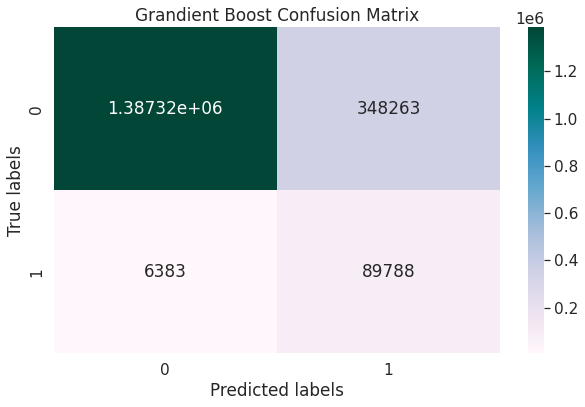

In [168]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap="PuBuGn", ax=ax)
classes = ["Not Transacting", "Transacting"]

tick_marks = np.arange(len(classes))

plt.xlabel('Predicted labels')
plt.ylabel('True labels') 
# plt.xticks(tick_marks, classes, rotation=0)
# plt.yticks(tick_marks, classes, rotation=0) 
plt.title('Grandient Boost Confusion Matrix')
plt.show()

In [96]:
GB = GBTClassifier(maxIter=10, seed=42, weightCol="weights")

GB_model = GB.fit(train)

In [97]:
GB_result = GB_model.transform(test)

In [98]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(GB_result, "areaUnderROC",  auc_eval)
model_evaluation(GB_result, "accuracy",  accuracy_eval)
model_evaluation(GB_result, "f1",  f1_eval)
model_evaluation(GB_result, "Precision",  precision_eval)
model_evaluation(GB_result, "Recall",  recall_eval)

areaUnderROC: 0.8691957740909679


accuracy: 0.8056842723594191


f1: 0.857324892526265


Precision: 0.9958631526586522


Recall: 0.7982328724896792


0.7982328724896792

In [107]:
GB_summary = GB_model.featureImportances

In [103]:
cm = GB_result.crosstab("prediction", "label")
cm

prediction_label,0,1
1.0,350184,90416
0.0,1385401,5755


In [126]:
#Save Model 
path = "home/jovyan/work/gradientBoostT_model"
GB_model.save(path)

# Naive Bayes

In [19]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel

### Hyperparameter Tuning: Naive Bayes

In [22]:
# Tune the Naive Bayes model with parameters, select the best model 
def NByModel(train):
    
    estimator = NaiveBayes(thresholds=[1, 10], weightCol="weights")
    
    param_grid = (ParamGridBuilder()
                 .addGrid(estimator.smoothing, [1, 2, 3])
                 .build())
    
    validator =  CrossValidator(estimator=estimator,
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                               numFolds=10)
    
    model = validator.fit(train)
    
    return model, model.avgMetrics


Nb_model, Acu_metrics = NByModel(train)
Acu_metrics

21/11/27 05:34:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/27 05:34:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


[0.9424071473141173, 0.9424071473141173, 0.9424071473141173]

In [23]:
# Evaluate the best Model

predictions = Nb_model.bestModel.transform(test)

auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(predictions, "areaUnderROC",  auc_eval)
model_evaluation(predictions, "accuracy",  accuracy_eval)
model_evaluation(predictions, "f1",  f1_eval)
model_evaluation(predictions, "precision_eval",  precision_eval)
model_evaluation(predictions, "recallByLabel",  recall_eval)

areaUnderROC: 0.5717020429451439


accuracy: 0.9421871690334302


f1: 0.9307439074724574


precision_eval: 0.9547911855090679


recallByLabel: 0.9856538285361996


0.9856538285361996

In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictandLabel = predictions.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

metrics = MulticlassMetrics(predictandLabel)
cm=metrics.confusionMatrix().toArray()

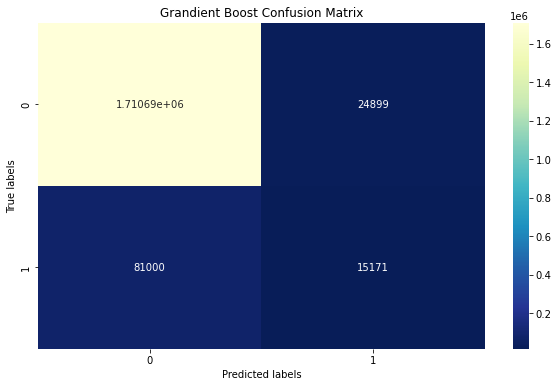

In [29]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu_r", ax=ax)
classes = ["Not Transacting", "Transacting"]

tick_marks = np.arange(len(classes))

plt.xlabel('Predicted labels')
plt.ylabel('True labels') 
# plt.xticks(tick_marks, classes, rotation=0)
# plt.yticks(tick_marks, classes, rotation=0) 
plt.title('Grandient Boost Confusion Matrix')
plt.show()

In [109]:
NB = NaiveBayes(weightCol="weights")

NBModel = NB.fit(train)

In [110]:
NB_result = NBModel.transform(test)

In [116]:
auc_eval = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="prediction")
accuracy_eval = MulticlassClassificationEvaluator(metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(metricName="f1")
precision_eval = MulticlassClassificationEvaluator(metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(metricName="recallByLabel")


model_evaluation(NB_result, "areaUnderROC",  auc_eval)
model_evaluation(NB_result, "accuracy",  accuracy_eval)
model_evaluation(NB_result, "f1",  f1_eval)
model_evaluation(NB_result, "Precision",  precision_eval)
model_evaluation(NB_result, "Recall",  recall_eval)

areaUnderROC: 0.8065732146824798


accuracy: 0.8223562526886768


f1: 0.8674341179403299


Precision: 0.9860089151980899


Recall: 0.8242079759850425


0.8242079759850425

In [124]:
cm = NB_result.crosstab("prediction", "label").toPandas()
cm

,prediction_label,0,1
0,1.0,305102,75873
1,0.0,1430483,20298


In [129]:
NB_summary = NB_result.summary

In [127]:
#Save Model 
path = "home/jovyan/work/navebayes_model"
NBModel.save(path)